In [1]:
# contenu de excel "Actif","Dates","Ouverture","Max","Min","Fermeture","Volume"
import numpy as np
import numpy.linalg as cm
import pandas as pd
import glob
import numpy.random as npr
import matplotlib.pyplot as plt

file_list = glob.glob("actions/*.xlsm")
BD = [pd.read_excel(file, engine="openpyxl") for file in file_list]

# ER est un vecteur de taille len(BD) qui contient les rendements moyens des len(BD) actions
ER = np.ones((len(BD), 1))
for j in range(len(BD)):
    bd = BD[j]
    St = [
        (bd.iloc[i, 3] + bd.iloc[i, 4]) / 2 for i in range(255)
    ]  # St est le prix moyen de chaque action
    Rt = [
        (St[i + 1] / St[i]) - 1 for i in range(254)
    ]  # Rt est le rendement de chaque action
    ER[j] = np.mean(Rt)  # ER[j] est le rendement moyen de l'action j

In [17]:
# Calcul de la matrice de covariance des rendements
SIGMA = np.ones((len(BD), len(BD)))

for i in range(len(BD)):
    for j in range(len(BD)):
        bdi = BD[i]
        Sti = [(bdi.iloc[k, 3] + bdi.iloc[k, 4]) / 2 for k in range(255)]
        Rti = [(Sti[k + 1] / Sti[k]) - 1 for k in range(254)]
        # Rendements centrés de l'action i
        RtiC = np.array(Rti) - ER[i]

        bdj = BD[j]
        Stj = [(bdj.iloc[k, 3] + bdj.iloc[k, 4]) / 2 for k in range(255)]
        Rtj = [(Stj[k + 1] / Stj[k]) - 1 for k in range(254)]
        # Rendements centrés de l'action j
        RtjC = np.array(Rtj) - ER[j]

        SIGMA[i, j] = np.mean(RtiC * RtjC)

print("Déterminant de SIGMA :", cm.det(SIGMA))
assert cm.det(SIGMA) != 0
sigmainv = cm.inv(SIGMA)

vect1 = np.ones((len(BD), 1))
vect1T = vect1.T

a = (vect1T @ sigmainv @ vect1)[0][0]
print("a :", a)

b = (vect1T @ sigmainv @ ER)[0][0]
print("b :", b)

Vect = ER - (b / a) * vect1
norm2 = Vect.T @ sigmainv @ Vect
norm = np.sqrt(norm2)[0][0]
print("Norm :", norm)

valsigma = np.linspace(1 / a, 2 / a, 100)

Déterminant de SIGMA : 1.7470455596539675e-48
a : 22541.52841897661
b : -4.842703763275818
Norm : 0.25708574674943396


In [11]:
# Frontière efficiente
def FE(a, b, sigma, norm):
    y = b / a + np.sqrt(sigma**2 - 1 / a) * norm
    return y


# Frontière non efficiente
def FNE(a, b, sigma, norm):
    y = b / a - np.sqrt(sigma**2 - 1 / a) * norm
    return y


# Constante
def cste(a, b):
    y = b / a
    return y

In [8]:
def get_x_opt(Sigmax, NS, BDLen, SIGMA, ER):
    Axe1 = []
    Axe2 = []

    Espmax = -(10**10)  # Initial maximum return (very negative)
    sig_opt = 0
    x_opt = np.array([1 for _ in range(BDLen)])

    for _ in range(NS):
        # Génération d'un vecteur de poids aléatoires uniformes
        x = np.array([npr.uniform() for _ in range(BDLen)])
        s = np.sum(x)

        # Si la somme est nulle, on force le premier poids à 1
        if s == 0:
            x[0] = 1
        else:
            x = x / s

        var = x.T @ SIGMA @ x
        sig = np.sqrt(var)
        esp = x.T @ np.squeeze(ER)

        Axe1.append(sig)
        Axe2.append(esp)

        # Vérification du risque et mise à jour du rendement optimal
        if sig <= Sigmax and esp > Espmax:
            Espmax = esp
            sig_opt = sig
            x_opt = x

    return x_opt, Espmax, Axe1, Axe2, sig_opt

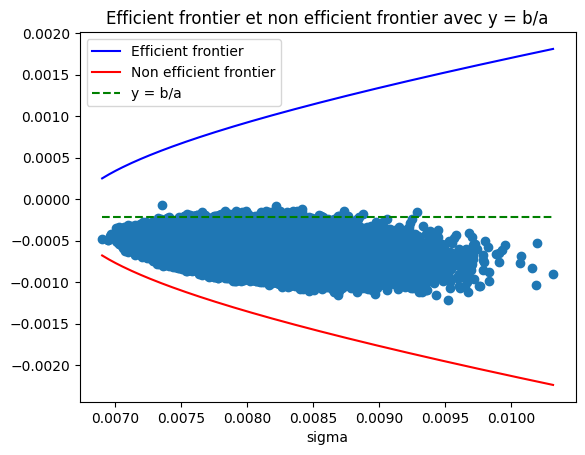

Min sigma: 0.006901317310133492
Max sigma: 0.010315153781476906
Moyenne sigma: 0.007999051516003554
Variance sigma: 1.2210366939298182e-07
Min esp: -0.0012149925160604847
Max esp: -6.874160181322004e-05
Moyenne esp: -0.0006171587350148013
Variance esp: 1.4743184632375546e-08


In [ ]:
# On fixe sigmax à 10000 pour pouvoir produire tous les portefeuilles possibles
x_opt, Espmax, Axe1, Axe2, _ = get_x_opt(10000, 200000, len(BD), SIGMA, ER)

axesigma = np.linspace(min(Axe1), max(Axe1), 200)
axeFE = [FE(a, b, sigma, norm) for sigma in axesigma]
axeFNE = [FNE(a, b, sigma, norm) for sigma in axesigma]
axeCste = [cste(a, b) for sigma in axesigma]

plt.scatter(Axe1, Axe2)
plt.title("Efficient frontier et non efficient frontier avec y = b/a")
plt.plot(axesigma, axeFE, label="Efficient frontier", color="blue")
plt.plot(axesigma, axeFNE, label="Non efficient frontier", color="red")
plt.plot(axesigma, axeCste, label="y = b/a", color="green", linestyle="--")
plt.legend()
plt.xlabel("sigma")
plt.show()

print("Min sigma:", min(Axe1))
print("Max sigma:", max(Axe1))
print("Moyenne sigma:", np.mean(Axe1))
print("Variance sigma:", np.var(Axe1))
print("Min esp:", min(Axe2))
print("Max esp:", max(Axe2))
print("Moyenne esp:", np.mean(Axe2))
print("Variance esp:", np.var(Axe2))

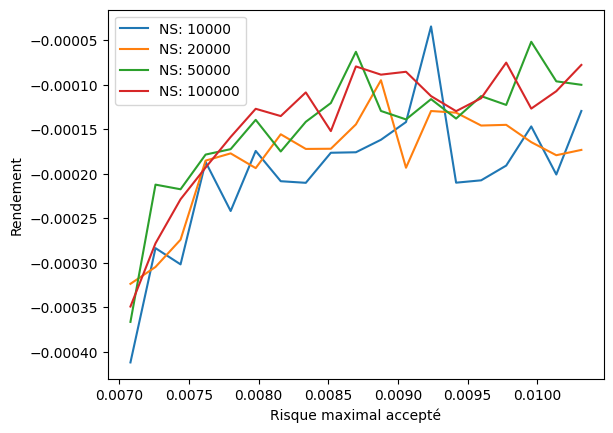

In [ ]:
# Échantillonnage du risque maximal possible
sig_mag_axe = np.linspace(min(Axe1), max(Axe1), 20)

# Différentes tailles d'échantillons de simulation
sims = [10000, 20000, 50000, 100000]

sim_res = []

# Pour chaque taille de simulation, on calcule le rendement maximal pour différents niveaux de risque accepté
for sim in sims:
    rendements = []
    for sig in sig_mag_axe:
        x, esp, _, _, _ = get_x_opt(sig, sim, len(BD), SIGMA, ER)
        if esp == -(10**10):
            esp = None
        rendements.append(esp)
    sim_res.append(rendements)

for i in range(len(sims)):
    plt.plot(sig_mag_axe, sim_res[i], label="NS: " + str(sims[i]))

plt.legend()
plt.xlabel("Risque maximal accepté")
plt.ylabel("Rendement")
plt.show()

In [ ]:
x_opt = np.zeros(len(BD))
x_opt, Espmax, _, _, sig_opt = get_x_opt(
    0.01, 200000, len(BD), SIGMA, ER
)  # On fixe sigmax à 0.01
print("Poids optimal:", x_opt)
print("Rendement maximal:", Espmax)
print("Risque quand rendement est maximal:", sig_opt)

Poids optimal: [7.03626530e-02 3.27158377e-02 1.27336855e-04 3.38770971e-02
 1.83473072e-02 1.83125214e-01 1.75028510e-01 1.83019431e-01
 6.98799953e-03 1.84349583e-01 4.73963771e-02 6.46626541e-02]
Rendement maximal: -9.25437025271678e-05
Risque quand rendement est maximal: 0.007949171092265988


In [ ]:
# Génère un BD ne contenant que les données de l'année 2019
BD2019 = []

for df in BD:
    # Conversion de la colonne de dates en datetime
    df_dates = pd.to_datetime(df.iloc[:, 1], format="%m/%d/%Y")

    # Filtrage des données de 2019
    df_2019 = df[df_dates.dt.year == 2019]
    BD2019.append(df_2019)

In [ ]:
def cal_theta_cash_fee(C, x_opt, St, k, old_theta):
    theta = np.array([int(C * x_opt[i] / St[i]) for i in range(len(St))])
    fee = np.abs(theta - old_theta).T @ St * k
    cash = C - theta.T @ St - fee

    # Ajustement si le cash est négatif
    C_available = C
    while cash < 0:
        C_available -= 1
        theta = np.array([int(C_available * x_opt[i] / St[i]) for i in range(len(St))])
        fee = np.abs(theta - old_theta).T @ St * k
        cash = C - theta.T @ St - fee

    return theta, cash, fee


def test_strategy_with_k(C, x_opt, S, k, freq=1):
    Cs = [C]
    S0 = np.array([S[i][0] for i in range(len(BD))])
    theta, cash, fee = cal_theta_cash_fee(C, x_opt, S0, k, np.zeros(len(BD), dtype=int))
    fees = [fee]

    for t in range(1, len(S[0])):
        St = np.array([S[i][t] for i in range(len(BD))])
        C = cash + theta.T @ St
        Cs.append(C)

        # Rééquilibrage si t est multiple de freq
        if freq == 0:
            fees.append(0)
            continue

        if t % freq != 0:
            fees.append(0)
        else:
            theta, cash, fee = cal_theta_cash_fee(C, x_opt, St, k, theta)
            fees.append(fee)

    return Cs, fees

Frais totaux pour k = 0.0 et freq = 0 : 0.0
Capital final pour k = 0.0 et freq = 0 : 120580.66499999998

Frais totaux pour k = 0.0 et freq = 1 : 0.0
Capital final pour k = 0.0 et freq = 1 : 120130.46899999987

Frais totaux pour k = 0.0 et freq = 10 : 0.0
Capital final pour k = 0.0 et freq = 10 : 120571.07350000012

Frais totaux pour k = 0.0 et freq = 30 : 0.0
Capital final pour k = 0.0 et freq = 30 : 120352.84750000006

Frais totaux pour k = 0.0 et freq = 60 : 0.0
Capital final pour k = 0.0 et freq = 60 : 120320.57500000001



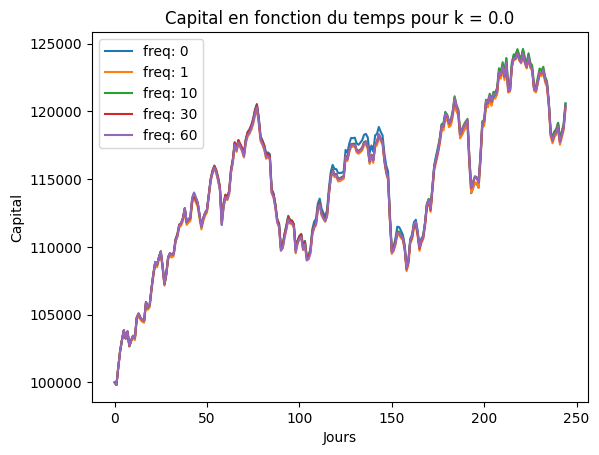

Frais totaux pour k = 0.01 et freq = 0 : 989.865805
Capital final pour k = 0.01 et freq = 0 : 119374.06369499999

Frais totaux pour k = 0.01 et freq = 1 : 2870.34588
Capital final pour k = 0.01 et freq = 1 : 116957.29719499983

Frais totaux pour k = 0.01 et freq = 10 : 1717.7089650000003
Capital final pour k = 0.01 et freq = 10 : 118600.52403500015

Frais totaux pour k = 0.01 et freq = 30 : 1386.82028
Capital final pour k = 0.01 et freq = 30 : 118733.86921999995

Frais totaux pour k = 0.01 et freq = 60 : 1265.790655
Capital final pour k = 0.01 et freq = 60 : 118829.57384499999



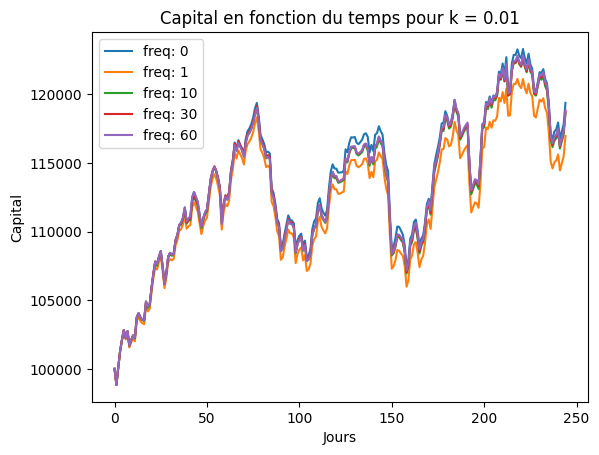

Frais totaux pour k = 0.02 et freq = 0 : 1960.5769299999997
Capital final pour k = 0.02 et freq = 0 : 118299.70907000001

Frais totaux pour k = 0.02 et freq = 1 : 5664.5982300000005
Capital final pour k = 0.02 et freq = 1 : 113951.26782000026

Frais totaux pour k = 0.02 et freq = 10 : 3388.634199999999
Capital final pour k = 0.02 et freq = 10 : 116708.71530000014

Frais totaux pour k = 0.02 et freq = 30 : 2745.3278299999997
Capital final pour k = 0.02 et freq = 30 : 117236.84817000003

Frais totaux pour k = 0.02 et freq = 60 : 2490.2693799999997
Capital final pour k = 0.02 et freq = 60 : 117439.28912



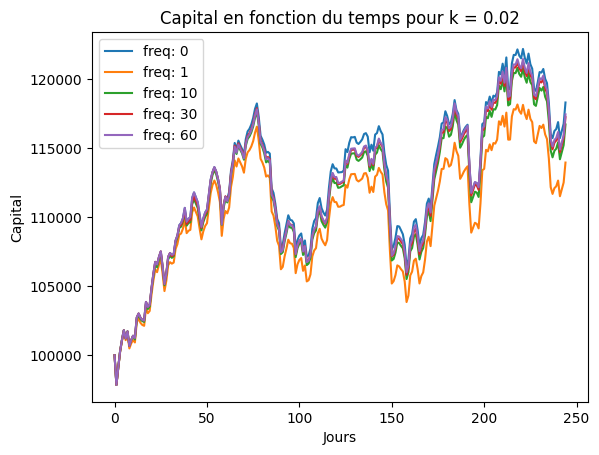

Frais totaux pour k = 0.05 et freq = 0 : 4760.908825000001
Capital final pour k = 0.05 et freq = 0 : 114924.14717499999

Frais totaux pour k = 0.05 et freq = 1 : 13269.460825000004
Capital final pour k = 0.05 et freq = 1 : 105545.4032999999

Frais totaux pour k = 0.05 et freq = 10 : 8219.817375
Capital final pour k = 0.05 et freq = 10 : 111226.77962499994

Frais totaux pour k = 0.05 et freq = 30 : 6631.009575000002
Capital final pour k = 0.05 et freq = 30 : 112720.71142499997

Frais totaux pour k = 0.05 et freq = 60 : 6048.799450000001
Capital final pour k = 0.05 et freq = 60 : 113300.57904999996



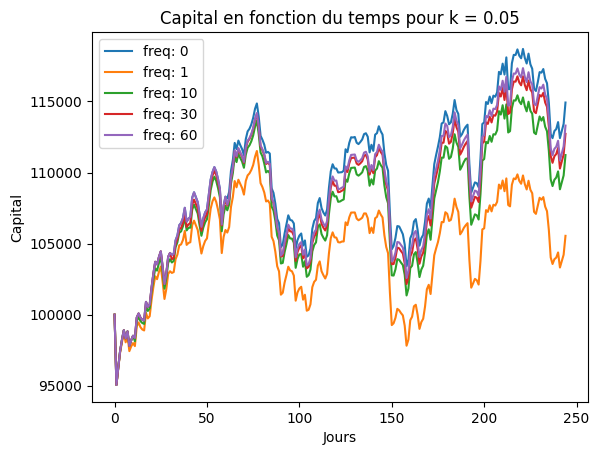

In [ ]:
# Initialisation du capital
C = 100000

# S stocke les prix de chaque action en 2019
S = [[] for _ in range(len(BD))]
for i in range(len(BD)):
    S[i] = [
        (BD2019[i].iloc[j, 3] + BD2019[i].iloc[j, 4]) / 2 for j in range(len(BD2019[i]))
    ]

ks = np.array([0, 0.01, 0.02, 0.05])
freqs = [0, 1, 10, 30, 60]
ks = np.round(ks, 3)

C_all = []
fees_all = []

for k in ks:
    for freq in freqs:
        Cs, fees = test_strategy_with_k(C, x_opt, S, k, freq)
        plt.plot(Cs, label="freq: " + str(freq))
        print("Frais totaux pour k =", k, "et freq =", freq, ":", sum(fees))
        print("Capital final pour k =", k, "et freq =", freq, ":", Cs[-1])
        print()
    plt.xlabel("Jours")
    plt.ylabel("Capital")
    plt.title("Capital en fonction du temps pour k = " + str(k))
    plt.legend()
    plt.show()

In [ ]:
BD_6_actions = BD[:6]
BD_last_6_actions = BD[-6:]

BD_30_actions = BD.copy()



# Chargement des nouveaux fichiers .xlsm


for file in glob.glob("new actions/*.xlsm"):

    BD_30_actions.append(pd.read_excel(file, engine="openpyxl"))



BD_dict = {"BD_6": BD_6_actions, "BD_12": BD, "BD_30": BD_30_actions}

In [5]:
def compute_statistics(BD):
    """
    selon les données de BD, on calcule les statistiques suivantes:
    - ER: vecteur de rendement moyen
    - SIGMA: matrice de covariance des rendements
    - déterminant de SIGMA & matrice inverse
    - a, b, norm, valsigma, etc.
    """

    lengthBD = len(BD)
    # -----------------------------
    # 1. calculer ER
    # -----------------------------
    ER = np.ones((lengthBD, 1))
    for j in range(lengthBD):
        bd = BD[j]
        St = [
            (bd.iloc[i, 3] + bd.iloc[i, 4]) / 2 for i in range(min(255, len(bd)))
        ]  # St est le prix moyen de chaque action
        Rt = [
            (St[i + 1] / St[i]) - 1 for i in range(min(254, len(bd) - 1))
        ]  # Rt est le rendement de chaque action
        ER[j] = np.mean(Rt)  # ER[j] est le rendement moyen de l'action j
    # -----------------------------
    # 2. calculer SIGMA(matrice de covariance)
    # -----------------------------
    SIGMA = np.ones((lengthBD, lengthBD))
    for i in range(lengthBD):
        for j in range(lengthBD):
            bdi = BD[i]
            Sti = [
                (bdi.iloc[k, 3] + bdi.iloc[k, 4]) / 2 for k in range(min(255, len(bd)))
            ]
            Rti = [
                (Sti[k + 1] / Sti[k]) - 1 for k in range(min(254, len(bd) - 1))
            ]  # Rti est les rendements de l'action i
            RtiC = np.array(Rti) - ER[i]  # RtiC est le rendement de l'action i centré

            bdj = BD[j]
            Stj = [
                (bdj.iloc[k, 3] + bdj.iloc[k, 4]) / 2 for k in range(min(255, len(bd)))
            ]
            Rtj = [
                Stj[k + 1] / Stj[k] - 1 for k in range(min(254, len(bd) - 1))
            ]  # Rtj est le rendement de l'action j
            RtjC = np.array(Rtj) - ER[j]

            SIGMA[i, j] = np.mean(RtiC * RtjC)

    print("Déterminant de SIGMA :", cm.det(SIGMA))
    assert cm.det(SIGMA) != 0
    sigmainv = cm.inv(SIGMA)

    vect1 = np.ones((len(BD), 1))
    vect1T = vect1.T

    a = (vect1T @ sigmainv @ vect1)[0][0]
    print("a :", a)

    b = (vect1T @ sigmainv @ ER)[0][0]
    print("b :", b)

    Vect = ER - (b / a) * vect1
    norm2 = Vect.T @ sigmainv @ Vect
    norm = np.sqrt(norm2)[0][0]
    print("Norm :", norm)

    return ER, SIGMA, a, b, norm

In [6]:
def draw_efficient_frontier(Axe1, Axe2, a, b, norm):
    axesigma = np.linspace(min(Axe1), max(Axe1), 200)
    axeFE = [FE(a, b, sigma, norm) for sigma in axesigma]
    axeFNE = [FNE(a, b, sigma, norm) for sigma in axesigma]
    axeCste = [cste(a, b) for sigma in axesigma]

    plt.scatter(Axe1, Axe2)
    plt.title("Efficient frontier et non efficient frontier avec y = b/a")
    plt.plot(axesigma, axeFE, label="Efficient frontier", color="blue")
    plt.plot(axesigma, axeFNE, label="Non efficient frontier", color="red")
    plt.plot(axesigma, axeCste, label="y = b/a", color="green", linestyle="--")
    plt.legend()
    plt.xlabel("sigma")
    plt.show()

    print("Min sigma:", min(Axe1))
    print("Max sigma:", max(Axe1))
    print("Moyenne sigma:", np.mean(Axe1))
    print("Variance sigma:", np.var(Axe1))
    print("Min esp:", min(Axe2))
    print("Max esp:", max(Axe2))
    print("Moyenne esp:", np.mean(Axe2))
    print("Variance esp:", np.var(Axe2))

In [ ]:
ER_6, SIGMA_6, a_6, b_6, norm_6 = compute_statistics(BD_6_actions)
ER_30, SIGMA_30, a_30, b_30, norm_30 = compute_statistics(BD_30_actions)

Déterminant de SIGMA : 3.089204880500314e-24
a : 16174.323837914628
b : -11.828757309366505
Norm : 0.15954174756544198
Déterminant de SIGMA : 6.220318109150358e-124
a : 33823.93090013263
b : -1.3353455510064887
Norm : 0.3257491531506524


NameError: name 'get_x_opt' is not defined

In [ ]:
# On fixe sigmax à 10000 et lancer beaucoup de simulations (200 000 fois) pour pouvoir produire tous les portefeuilles possibles
x_opt_6, Espmax_6, Axe1_6, Axe2_6, _ = get_x_opt(
    10000, 200000, len(BD_6_actions), SIGMA_6, ER_6
)
x_opt_30, Espmax_30, Axe1_30, Axe2_30, _ = get_x_opt(
    10000, 200000, len(BD_30_actions), SIGMA_30, ER_30
)

NameError: name 'Axe1' is not defined

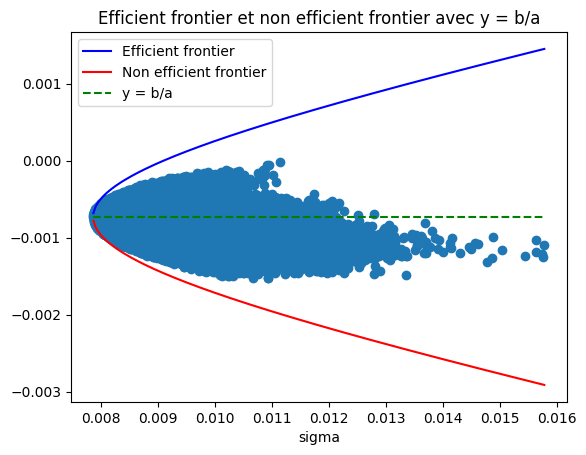

Min sigma: 0.00786904806401888
Max sigma: 0.01577936735586573
Moyenne sigma: 0.008988966298550363
Variance sigma: 3.8224518056441226e-07
Min esp: -0.0015282776297206291
Max esp: -2.180634145026856e-05
Moyenne esp: -0.0008447475210943241
Variance esp: 2.8406519225966867e-08


c:\Users\binhm\Projects\FinanceMarche\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


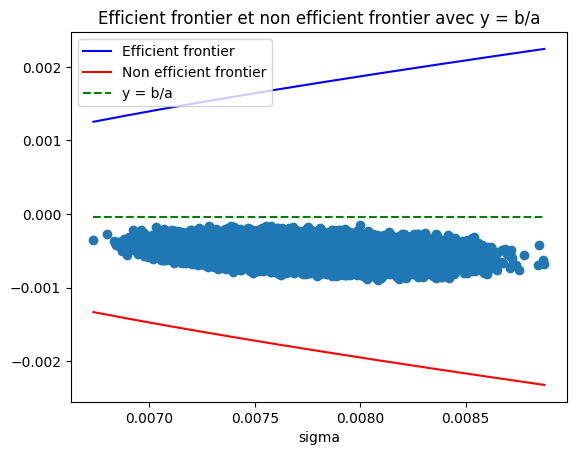

Min sigma: 0.006733773192521356
Max sigma: 0.008873536640147337
Moyenne sigma: 0.007684436663056527
Variance sigma: 5.7065198519513284e-08
Min esp: -0.0008989273083689857
Max esp: -0.00015349699366911786
Moyenne esp: -0.0005183672048383356
Variance esp: 7.097501283293389e-09


In [12]:
draw_efficient_frontier(Axe1_6, Axe2_6, a_6, b_6, norm_6)
draw_efficient_frontier(Axe1_30, Axe2_30, a_30, b_30, norm_30)

In [19]:
def get_x_opt_Esp_list(NS, BDLength, ER, SIGMA, valsigma):
    Esp_list = []
    x_opt_list = []

    for sig_target in valsigma:
        x, esp, _, _, _ = get_x_opt(sig_target, NS, BDLength, SIGMA, ER)

        if esp == -(10**10):
            esp = None

        Esp_list.append(esp)
        x_opt_list.append(x)

    return x_opt_list, np.array(Esp_list)

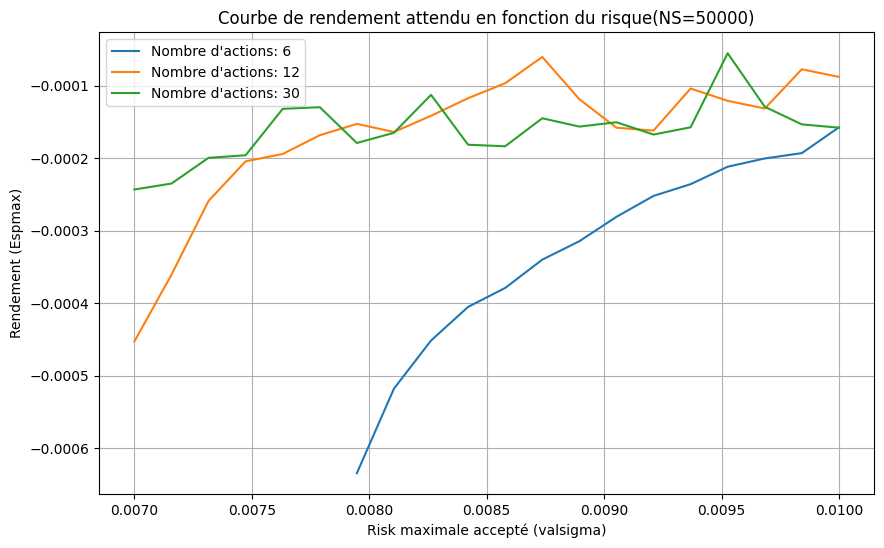

In [27]:
BD_results = {}
valsigma = np.linspace(0.007, 0.01, 20)
NS = 50000

_, Esp_6_list = get_x_opt_Esp_list(NS, len(BD_6_actions), ER_6, SIGMA_6, valsigma)
_, Esp_12_list = get_x_opt_Esp_list(NS, len(BD), ER, SIGMA, valsigma)
_, Esp_30_list = get_x_opt_Esp_list(NS, len(BD_30_actions), ER_30, SIGMA_30, valsigma)

BD_results["6"] = (valsigma, Esp_6_list)
BD_results["12"] = (valsigma, Esp_12_list)
BD_results["30"] = (valsigma, Esp_30_list)

plt.figure(figsize=(10, 6))
for BD_name, (valsigma, Esp_list) in BD_results.items():
    plt.plot(valsigma, Esp_list, label=f"Nombre d'actions: {BD_name}")

plt.xlabel("Risk maximale accepté (valsigma)")
plt.ylabel("Rendement (Espmax)")
plt.title(f"Courbe de rendement attendu en fonction du risque(NS={NS})")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Génère un BD ne contenant que les données de l'année 2019
BD2019 = []

for df in BD:
    # Conversion de la colonne de dates en datetime
    df_dates = pd.to_datetime(df.iloc[:, 1], format="%m/%d/%Y")

    # Filtrage des données de 2019
    df_2019 = df[df_dates.dt.year == 2019]
    BD2019.append(df_2019)

Frais totaux pour k = 0.0 et freq = 0 : 0.0
Capital final pour k = 0.0 et freq = 0 : 117594.591

Frais totaux pour k = 0.0 et freq = 1 : 0.0
Capital final pour k = 0.0 et freq = 1 : 117302.29750000003

Frais totaux pour k = 0.0 et freq = 10 : 0.0
Capital final pour k = 0.0 et freq = 10 : 117494.72100000014

Frais totaux pour k = 0.0 et freq = 30 : 0.0
Capital final pour k = 0.0 et freq = 30 : 117463.47350000005

Frais totaux pour k = 0.0 et freq = 60 : 0.0
Capital final pour k = 0.0 et freq = 60 : 117138.64349999998



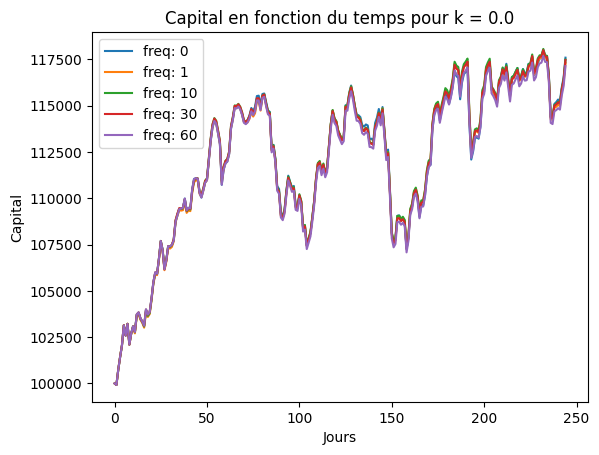

Frais totaux pour k = 0.01 et freq = 0 : 990.0845649999999
Capital final pour k = 0.01 et freq = 0 : 116605.163935

Frais totaux pour k = 0.01 et freq = 1 : 2793.6513999999984
Capital final pour k = 0.01 et freq = 1 : 114223.53962500018

Frais totaux pour k = 0.01 et freq = 10 : 1655.7370700000001
Capital final pour k = 0.01 et freq = 10 : 115690.91193000006

Frais totaux pour k = 0.01 et freq = 30 : 1344.58249
Capital final pour k = 0.01 et freq = 30 : 115923.92601

Frais totaux pour k = 0.01 et freq = 60 : 1235.1315149999998
Capital final pour k = 0.01 et freq = 60 : 115840.469485



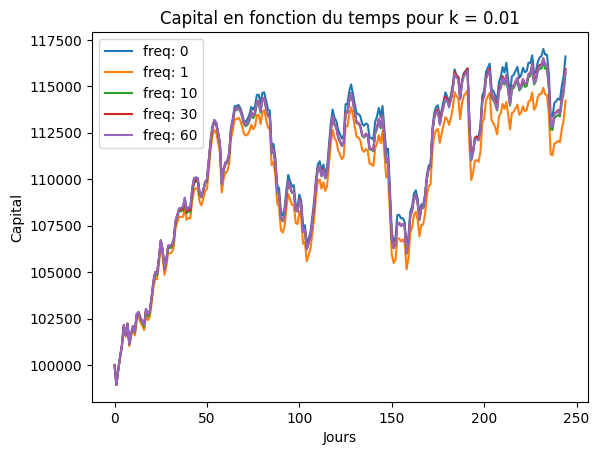

Frais totaux pour k = 0.02 et freq = 0 : 1960.6513499999999
Capital final pour k = 0.02 et freq = 0 : 115499.20365

Frais totaux pour k = 0.02 et freq = 1 : 5437.776529999997
Capital final pour k = 0.02 et freq = 1 : 111381.07127000012

Frais totaux pour k = 0.02 et freq = 10 : 3281.5456499999996
Capital final pour k = 0.02 et freq = 10 : 113934.53434999996

Frais totaux pour k = 0.02 et freq = 30 : 2635.6063999999997
Capital final pour k = 0.02 et freq = 30 : 114454.83360000004

Frais totaux pour k = 0.02 et freq = 60 : 2420.0486499999997
Capital final pour k = 0.02 et freq = 60 : 114504.67635000007



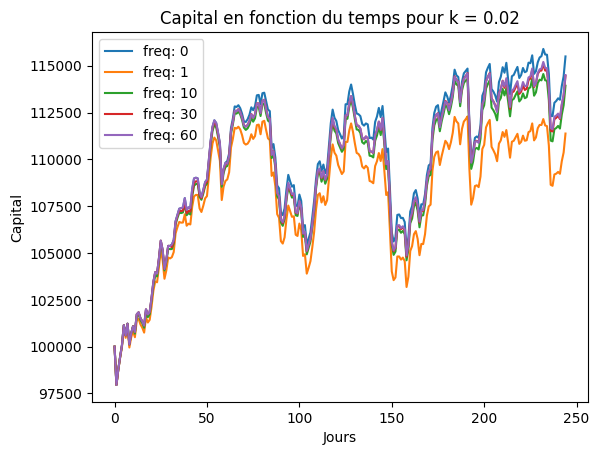

Frais totaux pour k = 0.05 et freq = 0 : 4761.477075000001
Capital final pour k = 0.05 et freq = 0 : 112201.188925

Frais totaux pour k = 0.05 et freq = 1 : 12796.689624999999
Capital final pour k = 0.05 et freq = 1 : 103204.67162499965

Frais totaux pour k = 0.05 et freq = 10 : 7886.2416
Capital final pour k = 0.05 et freq = 10 : 108621.93739999997

Frais totaux pour k = 0.05 et freq = 30 : 6465.035200000001
Capital final pour k = 0.05 et freq = 30 : 110087.3408

Frais totaux pour k = 0.05 et freq = 60 : 5948.6858250000005
Capital final pour k = 0.05 et freq = 60 : 110451.03017500005



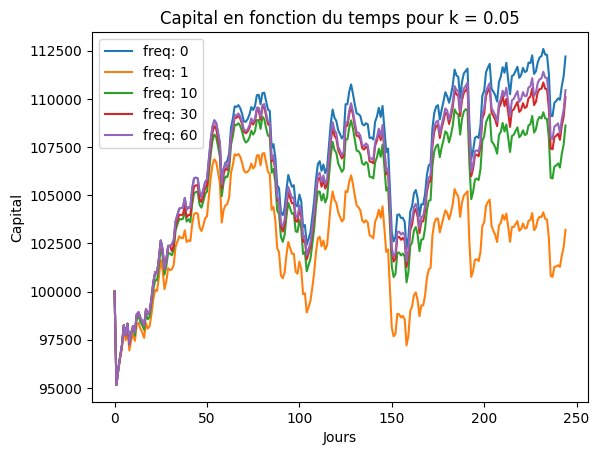

In [ ]:
# Initialisation du capital
C = 100000

# S stocke les prix de chaque action en 2019
S = [[] for _ in range(len(BD))]
for i in range(len(BD)):
    S[i] = [
        (BD2019[i].iloc[j, 3] + BD2019[i].iloc[j, 4]) / 2 for j in range(len(BD2019[i]))
    ]

ks = np.array([0, 0.01, 0.02, 0.05])
freqs = [0, 1, 10, 30, 60]
ks = np.round(ks, 3)

C_all = []
fees_all = []

for k in ks:
    for freq in freqs:
        Cs, fees = test_strategy_with_k(C, x_opt, S, k, freq)
        plt.plot(Cs, label="freq: " + str(freq))
        print("Frais totaux pour k =", k, "et freq =", freq, ":", sum(fees))
        print("Capital final pour k =", k, "et freq =", freq, ":", Cs[-1])
        print()
    plt.xlabel("Jours")
    plt.ylabel("Capital")
    plt.title("Capital en fonction du temps pour k = " + str(k))
    plt.legend()
    plt.show()

In [112]:
BD_CAC40 = pd.read_excel("CAC40.xlsm", engine="openpyxl")

S_CAC40 = [(BD_CAC40.iloc[i, 3] + BD_CAC40.iloc[i, 4]) / 2 for i in range(255)]
R_CAC40 = [(S_CAC40[i + 1] / S_CAC40[i]) - 1 for i in range(254)]

ER_CAC40 = np.mean(R_CAC40)
Sigma_CAC40 = np.sqrt(np.var(R_CAC40))

print("ER_CAC40:", ER_CAC40)
print("Sigma_CAC40:", Sigma_CAC40)

ER_CAC40: -0.0004970702060981592
Sigma_CAC40: 0.007726965879921416


In [113]:
df_dates_CAC40 = pd.to_datetime(BD_CAC40.iloc[:, 1], format="%m/%d/%Y")
BD_CAC40_2019 = BD_CAC40[df_dates_CAC40.dt.year == 2019]

S_CAC40_2019 = [
    (BD_CAC40_2019.iloc[i, 3] + BD_CAC40_2019.iloc[i, 4]) / 2
    for i in range(len(BD_CAC40_2019))
]

Frais totaux pour k = 0.0 : 195.42978
Capital final pour k = 0.0 : 126823.27522

Frais totaux pour k = 0.01 : 1172.57868
Capital final pour k = 0.01 : 125846.12632

Frais totaux pour k = 0.02 : 2149.7275799999998
Capital final pour k = 0.02 : 124868.97742

Frais totaux pour k = 0.05 : 4839.213600000001
Capital final pour k = 0.05 : 120892.88639999999



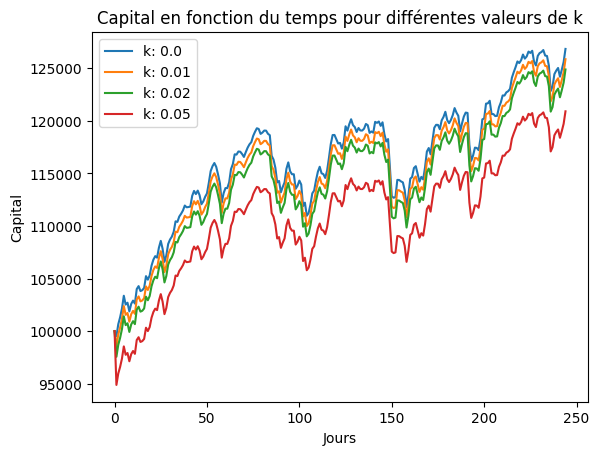

In [ ]:
# Initialisation des paramètres
ks = np.array([0, 0.01, 0.02, 0.05])
fee_management = 0.2 / 100
S0 = S_CAC40_2019[0]

for k in ks:
    C = 100000
    theta = int(C / S0)
    fee = theta * S0 * (k + fee_management)
    cash = C - theta * S0 - fee

    # Ajustement si le cash est négatif
    C_available = C
    while cash < 0:
        C_available -= 1
        theta = int(C_available / S0)
        fee = theta * S0 * (k + fee_management)
        cash = C - theta * S0 - fee

    Cs = [C]

    # Évolution du capital jusqu'à la fin de l'année 2019
    for t in range(1, len(BD_CAC40_2019)):
        St = S_CAC40_2019[t]
        C = cash + theta * St
        Cs.append(C)

    print("Frais totaux pour k =", k, ":", fee)
    print("Capital final pour k =", k, ":", Cs[-1])
    print()
    plt.plot(Cs, label="k: " + str(k))

plt.xlabel("Jours")
plt.ylabel("Capital")
plt.title("Capital en fonction du temps pour différentes valeurs de k")
plt.legend()
plt.show()